In [1]:
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as ssd
from tqdm import tqdm_notebook as tqdm

from hcp_dmd_utils import flat2mat,mat2flat

%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
#load RSN masks and labels
with h5py.File('RSN.h5','r') as hf:
    RSNs=np.array(hf['RSNs'])
    RSNlabels=np.array(hf['RSNlabels'])

rsn=[]        
for k in range(RSNs.shape[2]):
    r=RSNs[:,:,k]
    rsn.append(mat2flat(r))
rsn=np.vstack(rsn)
rsnNo=np.arange(RSNs.shape[2])
rsnNo=np.delete(rsnNo,[0,7])
rsn=rsn[rsnNo,:]
rlabs=RSNlabels[rsnNo]


scandirs=['LR','RL']
runlabels=['REST2']
#load runs performed with [nmodes,nframes] values of:
runsets=[[8,32]]

#use ulist=u120 for full gDMD
#or e.g. ulist=u120[:10] for smaller group gDMD
#or e.g. ulist=[u120[0]] for sDMD
#ulist=u120[:10]
u120=np.genfromtxt('u120.txt').astype(int).astype(str)
ulist=u120

## Calculate Clusters for DMD

HBox(children=(IntProgress(value=0, max=120), HTML(value=u'')))


8 clusters


HBox(children=(IntProgress(value=0, max=120), HTML(value=u'')))


10 clusters


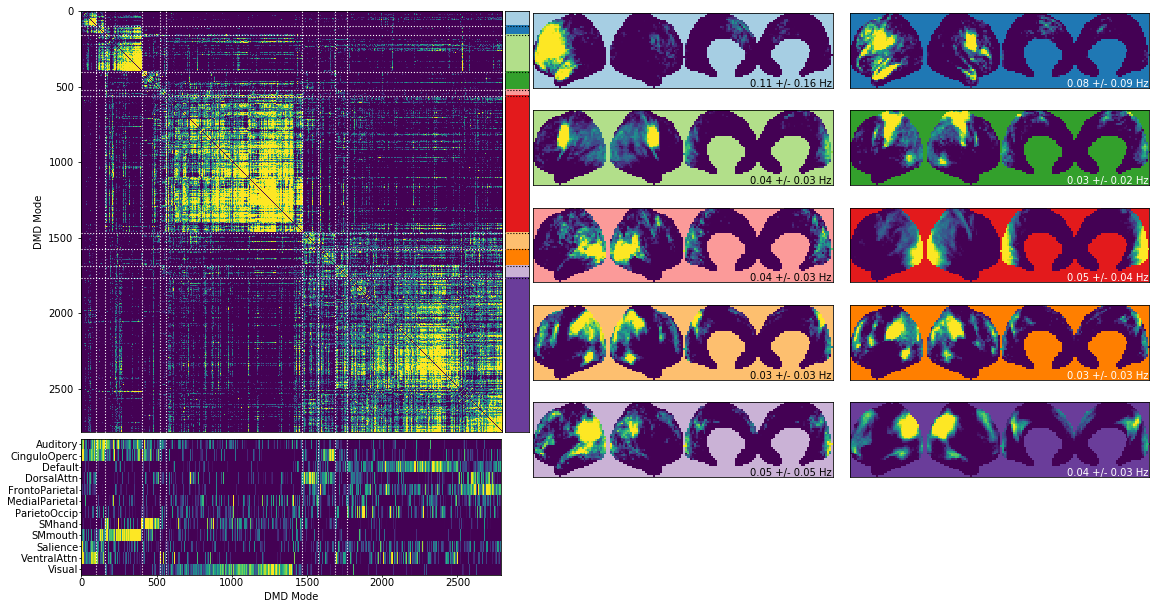

In [5]:
##CLUSTERING PARAMETERS:
#'mwhere' is boolean array of whether to keep modes for clustering
#  based upon if spatial continuity measure mpro is above thresh
mthresh=25
#z-score threshold to use for mode masks pre-clustering
zthresh=2.0
#only keep clusters with a certain number of modes inside
min_clust_size=400
#perform flat clustering with this threshold
fclust_thresh=0.955

RUNS=[]
MODES=[]
for runset in runsets:    
    for scandir in scandirs:
        for runlabel in runlabels:
            nmodes,nframes=runset
            freq=[]
            power=[]
            F=[]
            ux=[]
            jx=[]
            jno=[]

            #LOAD WINDOWED DMD RESULTS
            rx=[]
            runNo=-1
            for uid,u in enumerate(tqdm(ulist)):
                #print '{:}/{:}'.format(uid+1,len(ulist))
                fdir='./DMD_results/nmodes{:}_nframes{:}_{:}_{:}/'.format(nmodes,nframes,runlabel,scandir)
                try:
                    with h5py.File(fdir+'Modes_{:}.h5'.format(u),'r') as hf:
                        F.append(np.array(hf['F']))
                    with h5py.File(fdir+'{:}.h5'.format(u),'r') as hf:            
                        freq.append(np.array(hf['freq']))
                        power.append(np.array(hf['power']))
                        ux.append(np.array(hf['ux']))
                        jx.append(np.array(hf['jx']))
                        jno.append(np.array(hf['jno']))
                        runNo+=1
                        rx.append(runNo*np.ones(np.array(hf['jx']).shape))
                except:
                    pass
            freq=np.hstack(freq)
            power=np.hstack(power)
            F=np.vstack(F)
            ux=np.hstack(ux);
            jx=np.hstack(jx)
            rx=np.hstack(rx)
            jno=np.hstack(jno)
            

            winNo=np.unique(np.array(['{:03.0f}{:03.0f}{:01.0f}'.format(ux[k],jx[k],rx[k]) for k in range(len(ux))]),return_inverse=True)[1]
            
            #CALCULATE/THRESHOLD ON SPATIAL CONTINUITY
            Mflat=(F-np.mean(F,1)[:,None])/F.std(1)[:,None]
            mpro=[]
            for f in Mflat:
                m=flat2mat(f>2.0).astype(float)
                #mpro: product of masks with masks which have been shifted diagonally
                mpro.append(np.sum(np.sum(m[1:,1:]*m[:-1,:-1],0),0))
            mpro=np.hstack(mpro) 
            #calculate overlap between mode masks and rsn masks
            overlap=rsn.dot(Mflat.T)

            mwhere=mpro>mthresh
            
            #convert modes to zscores and threshold to create masks to cluster
            Fz=F[mwhere,:]
            Fz=(Fz-np.mean(Fz,1)[:,None])/np.std(Fz,1)[:,None]
            Fn=(Fz>zthresh).astype(float)
            
            #cluster modes based upon average correlation between groups
            method='average';metric='correlation';
            Z=sch.linkage(Fn, method, metric)
            ix=sch.dendrogram(Z,no_plot=True)['leaves']


            try:
                os.mkdir('./DMD_Clusters/')
            except:
                pass
            try:
                os.mkdir('./Figures/')
            except:
                pass
            
            cgroups=sch.fcluster(Z,fclust_thresh,'distance')[ix]
            cgroups=cgroups.astype(float)
            cun,count=np.unique(cgroups,return_counts=True)
            
            for k,c in enumerate(cun):
                if count[k]<min_clust_size:
                    cgroups[cgroups==c]=-1

            cgroups=np.unique(cgroups,return_inverse=True)[1].astype(float)
            cgroups[cgroups==0]=np.nan
            cgroups+=-1

            cif=np.isfinite(cgroups)
            cuni=np.unique(cgroups[cif])

            #get identified clusters in terms of original indices
            #so that they can be easily reloaded in the future...
            outfile='./DMD_Clusters/{:}_{:}_{:}m_{:}f_{:}clusters2.h5'.format(runlabel,scandir,runset[0],runset[1],len(cuni))
            indices=np.arange(len(jx))[mwhere][ix]
            cluster_indices=[]
            for c in cuni:
                cix=indices[cgroups==c]
                cluster_indices.append(cix)
            with h5py.File(outfile,'w') as hf:
                dt = h5py.special_dtype(vlen=np.dtype('int32'))
                hf.create_dataset('clusters',data=np.array(cluster_indices),dtype=dt)

            print '{:} clusters'.format(len(cuni))

            Ou=overlap[:,mwhere][:,ix][:,cif]
            Ou=(Ou-Ou.mean(1)[:,None])/Ou.std(1)[:,None]


            import skimage.transform as skit
            #'scale_factor' is a factor to scale down plotted image size -- use for many thousands of modes
            scale_factor=10
            Fsub=skit.downscale_local_mean(Fn[ix][cif],(scale_factor,1))
            C=ssd.cdist(Fsub,Fsub,metric=metric)
            C=np.abs(1-C);
            np.fill_diagonal(C,0)

            #FIGURE
            cplotthresh=min_clust_size
            plt.close('all')
            plt.figure(figsize=(16,9))

            a1=plt.subplot2grid((6,1),(0,0))    
            plt.imshow(C,vmin=C.mean(),vmax=C.mean()+2.0*C.std())
            yl=plt.ylim()
            #yt=np.arange(0,4000,500)
            #plt.yticks(yt,['{:}'.format(int(f)) for f in yt*scale_factor])
            plt.ylim(yl)
            plt.xticks([])
            plt.ylabel('DMD Mode')

            a2=plt.subplot2grid((6,1),(1,0))
            vmin=Ou.mean();vmax=Ou.mean()+2.0*Ou.std()
            plt.imshow(skit.downscale_local_mean(Ou,(1,scale_factor)),aspect='auto',vmin=vmin,vmax=vmax)
            plt.yticks(np.arange(len(rlabs)),rlabs,rotation=0)
            a2.tick_params(pad=1,length=2)
            xl=plt.xlim()
            #xt=np.arange(0,4000,500)
            #plt.xticks(xt,['{:}'.format(int(f)) for f in xt*scale_factor])
            plt.xlim(xl)
            plt.xlabel('DMD Mode')


            a4=plt.subplot2grid((6,1),(2,0))
            cbig=np.ones(cgroups.shape)*np.nan
            ck=-1
            for c in cuni:
                if np.sum(cgroups==c)>=cplotthresh:
                    ck+=1
                    cbig[cgroups==c]=ck
            plt.imshow(cbig[cif][:,None]%12,cmap='Paired',aspect='auto',vmin=0,vmax=12)
            plt.xticks([]);plt.yticks([])

            a5=plt.subplot2grid((6,1),(3,0),frameon=False)
            lplot=np.where(cbig[cif][1:]!=cbig[cif][:-1])[0].astype(float)/(C.shape[0]*scale_factor)
            cut=0.95
            for lp in lplot:
                plt.plot([0,cut],[lp]*2,':',c=[1,1,1],lw=1.1)
                plt.plot([cut,1],[lp]*2,':',c=[0,0,0],lw=1.1)
            plt.xlim([0,1])
            plt.ylim([0,1])
            plt.xticks([])
            plt.yticks([])
            a5.invert_yaxis()

            a6=plt.subplot2grid((6,1),(4,0),frameon=False)
            lplot=np.where(cbig[cif][1:]!=cbig[cif][:-1])[0].astype(float)/(C.shape[0]*scale_factor)
            cut=0.95
            for lp in lplot:
                plt.plot([lp]*2,[0,1],':',c=[1,1,1],lw=1.1)
            plt.xlim([0,1])
            plt.ylim([0,1])
            plt.xticks([])
            plt.yticks([])

            x1=0.0578
            y1=0.3
            y2=0.08
            w1=0.364
            a1.set_position([0.00,y1,0.48,0.65])
            a2.set_position([x1,y2,w1,0.21])    
            a4.set_position([0.426,y1,0.025*0.8,0.65])
            a5.set_position([x1,y1,w1+0.025,0.65])
            a6.set_position([x1,y2,w1,0.87])
            glist=np.unique(cgroups[np.isnan(cgroups)==False]).astype(int)

            #%
            cf=[]
            for gid in glist:
                cf.append(np.mean(np.absolute(freq[mwhere][ix][cgroups==gid])))
            cf=np.array(cf)

            MODESk=[]
            glist_big=[]
            for gid in glist:
                if np.sum(cgroups==gid)>=cplotthresh:
                    glist_big.append(gid)
            glist_big=np.array(glist_big)
            DMN=[]
            for gk,gid in enumerate(glist_big):
                a6=plt.axes([0.45+0.275*(gk%2),0.714-0.15*np.floor(gk/2),0.26,0.35])
                colors=mpl.cm.Paired(range(12))
                a6.set_facecolor(colors[gk%12])
                dmn=np.mean(F[mwhere][ix][cgroups==gid],0)
                vmin=dmn.mean()+0.0*dmn.std();vmax=dmn.mean()+2.0*dmn.std()
                DMN.append(dmn)
                D=flat2mat(dmn)
                D[D==0]=np.nan
                D=np.concatenate((D[:40],D[40:]),1)
                cm=mpl.cm.viridis
                cm.set_bad([1,1,1,0])
                plt.imshow(D,vmin=vmin,vmax=vmax,cmap=cm)
                plt.xticks([]);plt.yticks([])

                cf=freq[mwhere][ix][cgroups==gid]
                lum=np.sum(np.array([0.299,0.587,0.114])*colors[gid%12][:3])
                if lum>0.65:
                    tcolor=[0,0,0]
                else:
                    tcolor=[1,1,1]
                plt.text(159,40,'{:0.2f} +/- {:0.2f} Hz'.format(cf.mean(),cf.std()),color=tcolor,ha='right',va='bottom')

                MODESk.append(dmn)
            MODESk=np.vstack(MODESk)
            MODES.append(MODESk)
            DMN=np.vstack(DMN)
            RUNS.append('{:0.0f}_{:0.0f}__{:}_{:}'.format(runset[0],runset[1],scandir,runlabel))
            plt.savefig('./Figures/fig2b_{:}_{:}.svg'.format(runlabel,scandir))

            with h5py.File(outfile,'w') as hf:
                dt = h5py.special_dtype(vlen=np.dtype('int32'))
                hf.create_dataset('clusters',data=np.array(cluster_indices),dtype=dt)
                hf.create_dataset('modes',data=DMN)
        